In [1]:
import pandas as pd
import spacy

In [2]:
labels = ['Quantity', 'Unit', 'Food', 'Variety', 'Preparation', 'Alteration', 'Brand', 'Optional', 'State']

In [3]:
ner_ds = pd.read_json("../data/NER_data/first_test.jsonl", lines=True)

In [4]:
ner_ds.head()

,id,text,label,Comments
0,2101,5 ounces rum\n4 ounces triple sec\n3 ounces Ti...,"[[0, 1, Quantity], [2, 8, Unit], [9, 12, Food]...",[]
1,2102,"2 tubes cinnamon roll, refrigerated, with icin...","[[0, 1, Quantity], [2, 7, Unit], [8, 21, Food]...",[]
2,2103,4 ripe coconuts\n1 cup evaporated milk\n1 cup ...,"[[0, 1, Quantity], [2, 6, Variety], [7, 15, Fo...",[]
3,2104,1 sheet graham cracker (broken in half)\n2 pie...,"[[0, 1, Quantity], [2, 7, Unit], [8, 22, Food]...",[]
4,2105,1 (8 ounce) package crescent rolls\n8 slices d...,"[[0, 1, Quantity], [3, 4, Quantity], [5, 10, U...",[]


In [7]:
from sklearn.model_selection import train_test_split
from spacy.training.example import Example
nlp = spacy.blank("en")
def ds_to_data(ds):
    examples = []
    for i, [text, annotations] in ds[['text', 'label']].iterrows():
        try:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, {"entities": annotations})
            examples.append(example)
        except TypeError as e:
            print(e)
            continue
    return examples
    
def ds_to_data_split(ds, train_size=0.8, random_state=123):
    train_ds, val_ds = train_test_split(ds, train_size=train_size, random_state=random_state)

    return ds_to_data(train_ds), ds_to_data(val_ds)

In [8]:
train_ds, val_ds =  ds_to_data_split(ner_ds)

/home/naabzer/develop/recipe_tm/env/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "2 cups raspberry sorbet (I used President's Choice..." with entities "[[0, 1, 'Quantity'], [2, 6, 'Unit'], [7, 23, 'Food...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


In [10]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [11]:
import random
import spacy
import mlflow
import mlflow.spacy
from spacy.util import minibatch, compounding


def train_ner(train_data, val_data, labels, iterations, drop_rate):
    mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URL"))
    mlflow.set_experiment("jupyter_NER")
    
    with mlflow.start_run(run_name="jupyer_test1") as run:
        mlflow.log_params({"iterations": iterations, "drop_rate": drop_rate})
        nlp = spacy.blank('en')
        if "ner" not in nlp.pipe_names:
            ner = nlp.create_pipe("ner")
            nlp.add_pipe("ner", last=True)
        else:
            ner = nlp.get_pipe("ner")

        [ner.add_label(label) for label in labels]
    
        for itn in range(iterations):
            print(f"Starting iteration {itn}")
            random.shuffle(train_data)
    
            losses = {}
    
            nlp.initialize(lambda: train_data)
            for batch in minibatch(train_data, size=compounding(4.0, 32.0, 1.001)):
                nlp.update(
                        train_data,
                        drop=drop_rate,
                        losses=losses
                        )
            print(f"Losses: {losses}")
            mlflow.log_metric("loss", losses['ner'], itn)
    
        mlflow.spacy.log_model(spacy_model=nlp, artifact_path="model")
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
        print(model_uri)

In [ ]:
train_ner(train_ds, val_ds, labels, 1000, 0.1)

Starting iteration 0
Losses: {'ner': np.float32(60350.38)}
Starting iteration 1
Losses: {'ner': np.float32(57680.277)}
Starting iteration 2
Losses: {'ner': np.float32(61583.824)}
Starting iteration 3
Losses: {'ner': np.float32(60934.285)}
Starting iteration 4
Losses: {'ner': np.float32(59891.332)}
Starting iteration 5
Losses: {'ner': np.float32(60057.273)}
Starting iteration 6
Losses: {'ner': np.float32(61732.812)}
Starting iteration 7
Losses: {'ner': np.float32(61113.28)}
Starting iteration 8


In [88]:
nlp2 = mlflow.spacy.load_model(model_uri=model_uri)
pred_ents = []
true_ents = []

for recipe in test_set:
  # tok.ent_type_ gets the ent per token, as opposed to breaking the Doc into
  # entities. This ensures that `true_ents` and `pred_ents` are the same length.
  true_ents += [tok.ent_type_ for tok in recipe]
  # `recipe.text` grabs the raw recipe, because `recipe` already contains entity
  # labels.
  pred_ents += [tok.ent_type_ for tok in nlp2(recipe.text)]

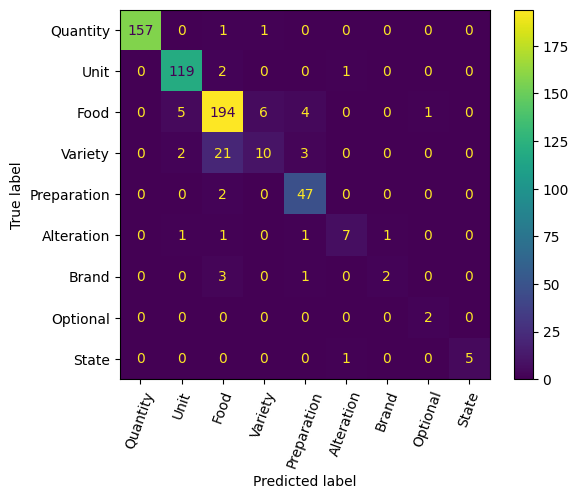

In [95]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# create and display the confusion matrix
cm = confusion_matrix(true_ents, pred_ents, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot()
plt.xticks(rotation=70)
plt.show()

### Testing on real data

In [96]:
nlg_ds = pd.read_csv('../data/recipenlg/RecipeNLG_dataset.csv', converters={'ingredients': pd.eval}, nrows=5)


In [107]:
nlg_ds.head()
ingredient_texts = []
for ingredient in nlg_ds['ingredients']:
    ingredient_texts.append(nlp("\n".join(ingredient)))

In [97]:
from spacy import displacy

In [108]:
displacy.render(ingredient_texts, style='ent', jupyter=True)